In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## folders
input_files_folder = '../../../fred_input_files'

## Parameters
alpha = 0.05

In [3]:
data_folder             = '../data'
geo_colombia_info_file  = 'geoinfo_municipios_colombia.csv'

In [4]:
df_mun_info = pd.read_csv(f'{data_folder}/{geo_colombia_info_file}')[['COD_DEPTO','NOM_DEPART']].drop_duplicates()

In [5]:
## Load known info
# Load and preprocess data
df_contacts_11 = pd.read_csv(f'{input_files_folder}/contacts/community_survey_11001.csv')
df_contacts_11_ = df_contacts_11.copy()
df_contacts_11['Date'] = pd.to_datetime(df_contacts_11['Date'])
df_contacts_11 = df_contacts_11[['Date', 'Contacts_total']]

df_mobility_11 = pd.read_csv(f'{input_files_folder}/mobility_trends/11_mobility_trends.csv')
df_mobility_11['date'] = pd.to_datetime(df_mobility_11['date'])
df_mobility_11['mobility_trend'] = 1 + df_mobility_11['mobility_trend'].ewm(alpha=alpha).mean()

df_combined_11 = pd.merge(df_contacts_11, df_mobility_11, left_on='Date', right_on='date', how='inner')

# Drop rows with NaN values created by lagging
df_combined_11.dropna(inplace=True)

In [6]:
depart_list = df_mun_info.COD_DEPTO.unique()

In [7]:
for dept in depart_list:
    if dept == 999:
        continue

    # Load mobility data for another population (e.g., population 8)
    df_mobility_8 = pd.read_csv(f'{input_files_folder}/mobility_trends/{dept}_mobility_trends.csv')
    df_mobility_8['date'] = pd.to_datetime(df_mobility_8['date'])
    df_mobility_8['mobility_trend'] = 1 + df_mobility_8['mobility_trend'].ewm(alpha=alpha).mean()

    df_combined_88 = pd.merge(df_contacts_11, df_mobility_8, left_on='Date', right_on='date', how='inner')

    # Drop rows with NaN values created by lagging
    df_combined_88.dropna(inplace=True)

    a1 = (df_combined_11['mobility_trend'].ewm(alpha=alpha).mean())
    a2 = (df_combined_88['mobility_trend'].ewm(alpha=alpha).mean())

    frac = a2 / a1
    contact_estimation = frac * df_combined_11['Contacts_total'].to_numpy()

    df_ = pd.DataFrame({'Date':df_contacts_11_.Date,
                        'day':df_contacts_11_.day,
                        'Contacts_total':contact_estimation})

    df_['Contacts_Prop'] = df_.Contacts_total / df_.iloc[0].Contacts_total

    #df_.to_csv(f'{input_files_folder}/contacts/{dept}_contacts.csv', index=False)
    #df_.to_csv(f'../output_files/{dept}_contacts.csv', index=False)

In [10]:
df_mobility_8

,date,mobility_trend
0,2020-03-01,1.015290
1,2020-03-02,1.035911
2,2020-03-03,1.033341
3,2020-03-04,1.037702
4,2020-03-05,1.037595
...,...,...
808,2022-05-18,0.984981
809,2022-05-19,0.983957
810,2022-05-20,0.983643
811,2022-05-21,0.979757


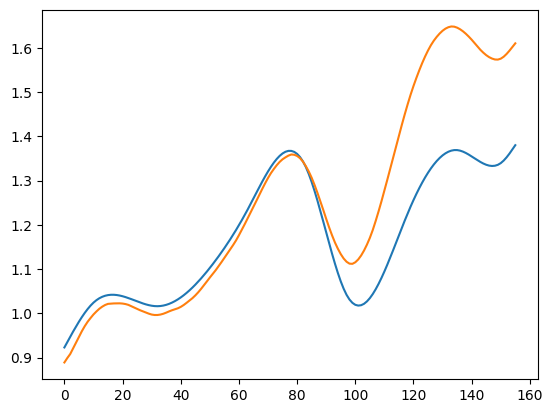

In [8]:
plt.plot(df_combined_11['Contacts_total'].to_numpy())
plt.plot(contact_estimation)

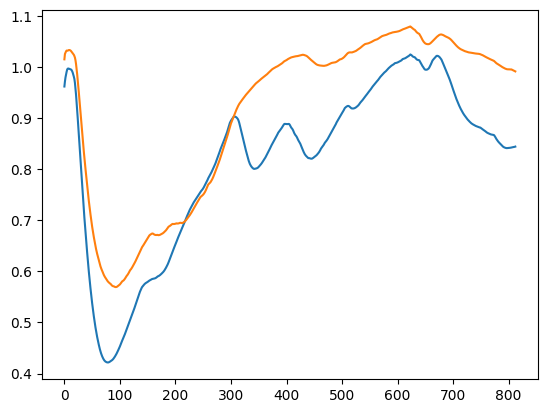

In [9]:
plt.plot(df_mobility_11['mobility_trend'].ewm(alpha=alpha).mean())
plt.plot(df_mobility_8['mobility_trend'].ewm(alpha=alpha).mean())